In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero

import sys
sys.setrecursionlimit(10**6)

# Plot Image

### 1 is obstacle, 0 is free space

Assuming:
1. Perfect Localization
2. Normal distributed uncertainty in position and heading
3. Resolution of sensor is 128 pixel, with Gaussian noise of covariance σ_r=(0.05)2 m2
4. Update freq is 5 Hz

Input: x,y speed and theta

In [3]:
# Get map generated from matlab
my_data = np.genfromtxt('img_binarized_in_matlab.csv', delimiter=',')

In [4]:
my_data.shape

(876, 676)

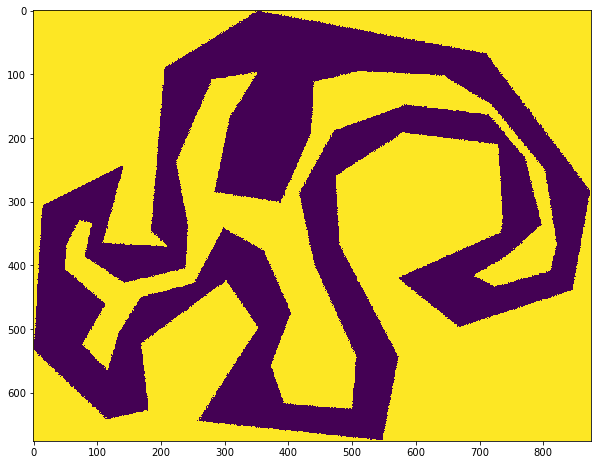

In [5]:
plt.figure(figsize=(10,10))
imgplot = plt.imshow(my_data.T)

In [6]:
# Util Functions

def sample_normal_distribution(mu, sigma):
    mu, sigma = 0, 0.1 # mean and standard deviation
    return np.random.normal(mu, sigma, 1)

def inverse_measurement_model(measurement):
    """
    return the measurement with consideration of measurement resolution
    """
    
    return measurement

def sector_mask(shape,centre,radius,angle_range): 
    """ 
    Return a boolean mask for a circular sector. The start/stop angles in 
    "angle_range" should be given in clockwise order. 
    Reference: http://hk.uwenku.com/question/p-cocpxpri-oa.html
    """ 

    x,y = np.ogrid[:shape[0],:shape[1]] 
    cx,cy = centre 
    tmin,tmax = np.deg2rad(angle_range) 

    # ensure stop angle > start angle 
    if tmax < tmin: 
        tmax += 2*np.pi 

    # convert cartesian --> polar coordinates 
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy) 
    theta = np.arctan2(x-cx,y-cy) - tmin 

    # wrap angles between 0 and 2*pi 
    theta %= (2*np.pi) 

    # circular mask 
    circmask = r2 <= radius*radius 

    # angular mask 
    anglemask = theta <= (tmax-tmin) 

    return circmask*anglemask 

def keep_only_one_part(mask):
    """
    Keep only one isolated part of the mask, delete all other part
    """
    

In [7]:
class drone(object):
    def __init__(self, start_x, start_y, start_theta, map_data, print_info):
        self.print_info = print_info
        
        self.map_data = map_data
        self.cur_x = start_x
        self.cur_y = start_y
        self.cur_theta = start_theta # theta = 0 means heading to the right
        
        if self.map_data[self.cur_x,self.cur_y] == 1:
            print ("Initial position in the wall!")
        
        # record trajectory, store (x,y) in a tuple 
        self.trajectory = [(self.cur_x, self.cur_y)]
        
        # size of the map in meters
        map_real_x = 87.6
        map_real_y = 67.6
        grid_cell_size = 0.1
        
        # speed limit 
        self.linear_speed_limit = 20 / grid_cell_size # in pixel
        self.angular_speed_limit = 50 # in degree
        self.freq = 5 # update frequency
        self.t = 1/self.freq # unit time interval

        # Time
        self.cur_time = 0
        
        # sensor view field
        self.view_width = 69 # in degree
        self.alpha = self.view_width/2 
        self.view_min = 0.3/grid_cell_size # in pixel
        self.view_max = 10/grid_cell_size # in pixel
        
        if self.print_info:
            print ("Initializing Drone Map in dmap")
        
        # initialize dmap to 1
        self.dmap =  np.ones(self.map_data.shape)  
        
        if self.print_info:
            print ("dmap size: ", self.dmap.shape)
            print ("current position: ", (self.cur_x,self.cur_y))
            print ("current theta: ", (self.cur_theta))
        

    def get_cur_pos(self):
        return self.cur_x, self.cur_y, self.cur_theta
    
    def get_cur_map(self):
        return self.dmap
    
    def plot_cur_map(self, figsize = (10,10), with_trajectory = False):
        plt.figure(figsize=figsize)
        imgplot = plt.imshow(self.dmap.T)
        plt.show()
        
        if with_trajectory:
            pass
        
    def get_cur_time(self):
        return self.cur_time
    
    def get_traj(self):
        """
        Get the current trajectory of the drone
        """
        return self.trajectory
        
    def update_map(self,x_speed,y_speed,theta,deterministic = True):   
        """
        Update map,
        """
        if self.print_info:
            print ("updating dmap")
            
        # check speed limits 
        if abs(x_speed) > self.linear_speed_limit:
            print ("WARNING: LINEAR SPEED X LIMIT EXCEEDS!")
        if abs(y_speed) > self.linear_speed_limit:
            print ("WARNING: LINEAR SPEED Y LIMIT EXCEEDS!")
        if abs(theta - self.cur_theta) > self.angular_speed_limit:
            print ("WARNING: ANGULAR SPEED LIMIT EXCEEDS!")
        
        # check valid position
        x = self.cur_x + int(x_speed * self.t)
        y = self.cur_y + int(y_speed * self.t)
        if self.map_data[x,y] == 1:
            print ("Opps, you are in the wall, i moved you back to:")
            x = self.cur_x
            y = self.cur_y
            print ("(x,y) = ",(x,y))
        
        if x == self.cur_x and y == self.cur_y:
            print ("WARNING: Speed too low, no update in x-y position")
        
        # update current pos
        self.cur_x = x
        self.cur_y = y
        self.cur_theta = theta
        
        
        ## get index mask for mapping
        
        cur_theta = self.cur_theta + 90 # correct offset
        angle_range = (cur_theta - self.alpha, cur_theta + self.alpha) # get angle range, always the same
        
        # first get the larger sector 
        mask1 = sector_mask(self.map_data.shape,(self.cur_x,self.cur_y), self.view_max , angle_range) 
        
        # get intersection between the ground truth map
        mask1 = mask1 & (~self.map_data.astype(bool))
        return mask1
        # restrict to only single part of sector
        
#         self.mask_copy = np.zeros(mask1.shape)
#         ground_truth_map = copy.deepcopy(self.map_data)
#         self.dfs(ground_truth_map, self.cur_x, self.cur_y)
    
        # then opt out the smaller sector
        mask2 = sector_mask(self.map_data.shape,(self.cur_x,self.cur_y), self.view_min , angle_range)
        mask = self.mask1_single_part.astype(bool) & (~mask2)
        
        # update dmap
        if self.print_info:
            print ("...")
            
        if deterministic:
            self.dmap[mask] = 0
    
        else:
            print ("idk, use inverse measurement model, I already have the mask for you")
            pass
        
        # update cur time
        self.cur_time += self.t
        
        # update trajectory
        self.trajectory.append((self.cur_x, self.cur_y))
        
        if self.print_info:
            print ("update dmap complete")
            
            
    def dfs(self, grid, i, j):
        """
        recursively prune out all disconnected part from mask
        """
        if i<0 or j<0 or i>=len(grid) or j>=len(grid[0]) or grid[i,j] != 0:
            return
        grid[i,j] = 1
        self.mask_copy[i,j] = 1 # mark the point in a mask copy 
        self.dfs(grid, i+1, j)
        self.dfs(grid, i-1, j)
        self.dfs(grid, i, j+1)
        self.dfs(grid, i, j-1)

In [8]:
d = drone(start_x=350,
              start_y=250,
              start_theta=0,
              map_data=my_data,
              print_info=True)

Initializing Drone Map in dmap
dmap size:  (876, 676)
current position:  (350, 250)
current theta:  0


In [9]:
mask = d.update_map(10,10,0,deterministic=True)

updating dmap


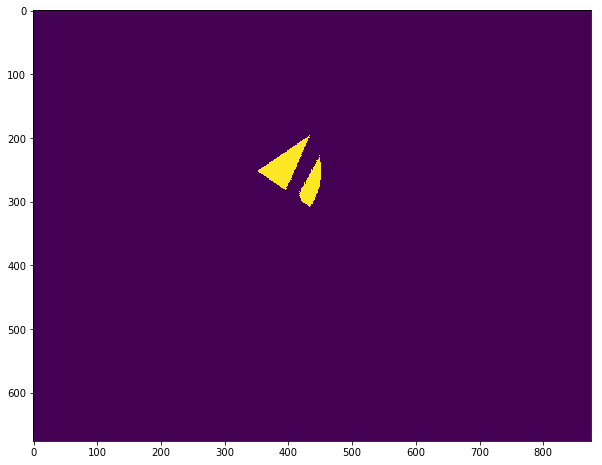

In [10]:
plt.figure(figsize=(10,10))
imgplot = plt.imshow(mask.T)
plt.show()

In [11]:
d.get_traj()

[(350, 250)]

In [12]:
d.get_cur_pos()

(352, 252, 0)

In [13]:
d.get_cur_time()

0

## Not used functions

In [304]:
arr = np.zeros(my_data.shape)
x_size ,y_size= np.array(my_data.shape)
x = np.arange(0, x_size)
y = np.arange(0, y_size)

cx = int(x_size/3)
cy = int(y_size/2)
# cx = 0
# cy = 0

mask1 = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 > 100**2
mask2 = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < 10**2
mask3 = abs(np.radians(20) - (np.arctan((y[:,np.newaxis]-cy) / (x[np.newaxis,:]-cx)))) > np.radians(69/2) # fan
# mask4 = np.radians(20) - (np.arctan((y[:,np.newaxis]-cy) / (x[np.newaxis,:]-cx))) > np.radians(69/2) # fan
# mask4 = (x[np.newaxis,:]-cx) < 0

arr[mask1.T] = 1
arr[mask2.T] = 1
arr[mask3.T] = 1
# arr[mask4.T] = 1

# plt.figure(figsize=(10,10))
# imgplot = plt.imshow(arr.T)

In [21]:
mask_copy = np.zeros(my_data.shape)
def dfs(grid, i, j):
#     print ("start")
#     print (grid[i,j])
    if i<0 or j<0 or i>=grid.shape[0] or j>=grid.shape[1] or grid[i,j] != 0:
        return
    grid[i,j] = 1
#     print ("yes")
#     result.append([i,j])
    mask_copy[i,j] = 1
    dfs(grid, i+1, j)
    dfs(grid, i-1, j)
    dfs(grid, i, j+1)
    dfs(grid, i, j-1)